In [28]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv("data/creditcard.csv")

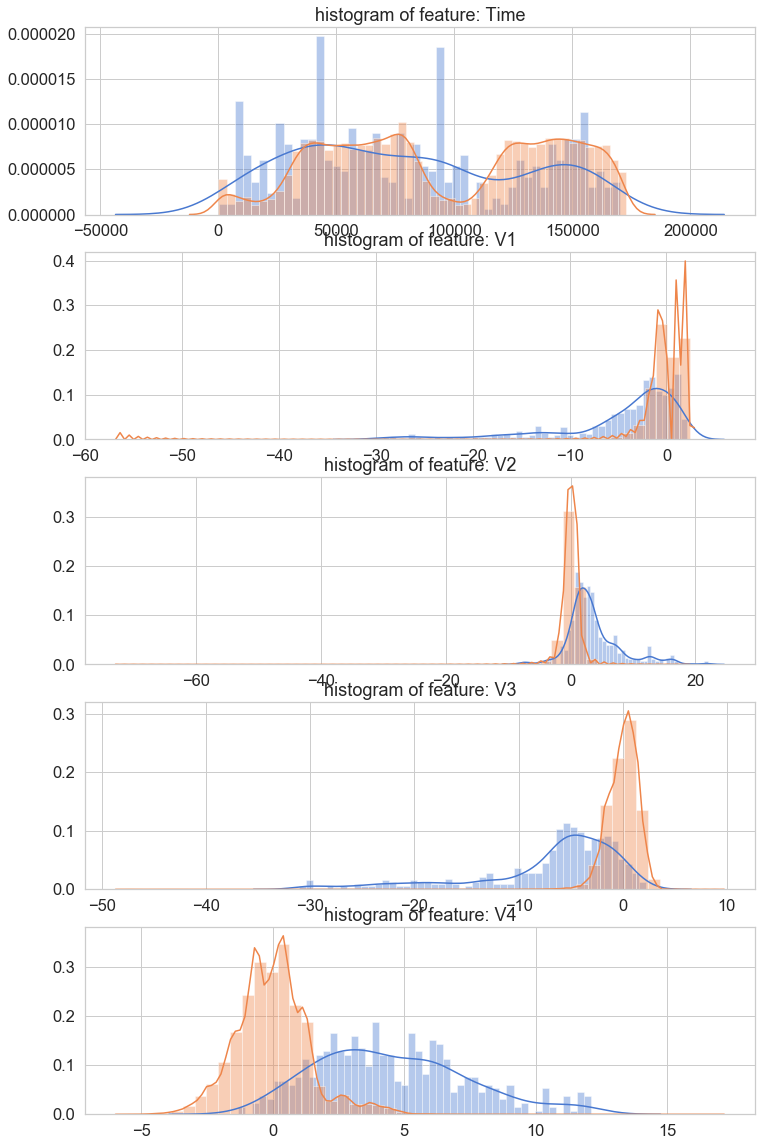

In [33]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

(2,)


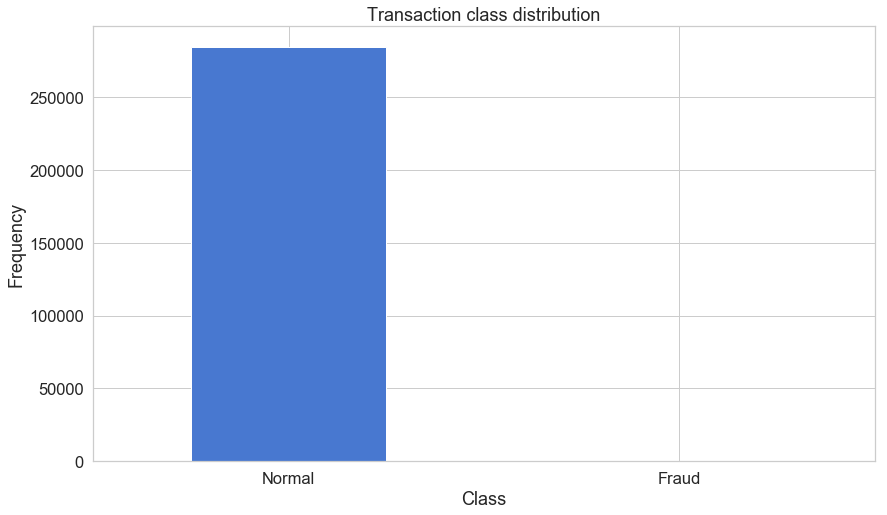

In [4]:
count_classes = pd.value_counts(df['Class'], sort = True)
print(count_classes.shape)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [5]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print(frauds.shape)
print(normal.shape)

(492, 31)
(284315, 31)


In [6]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

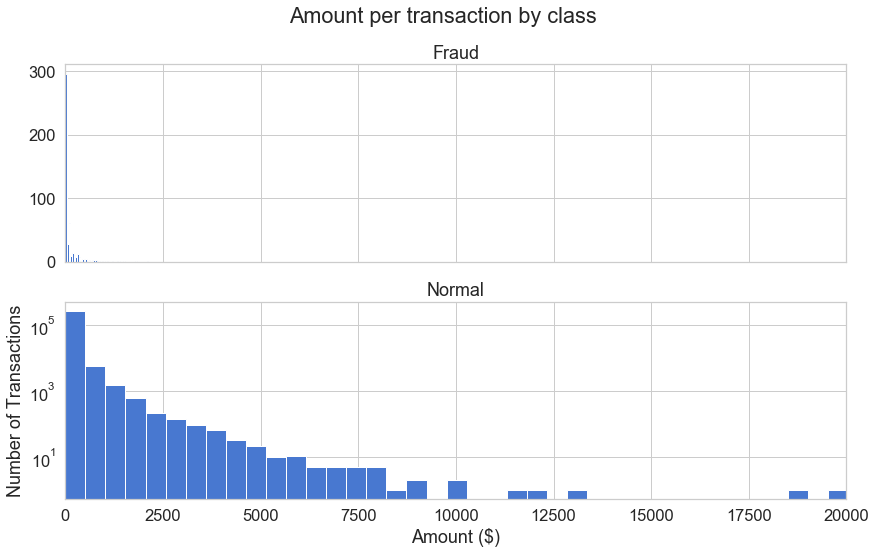

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

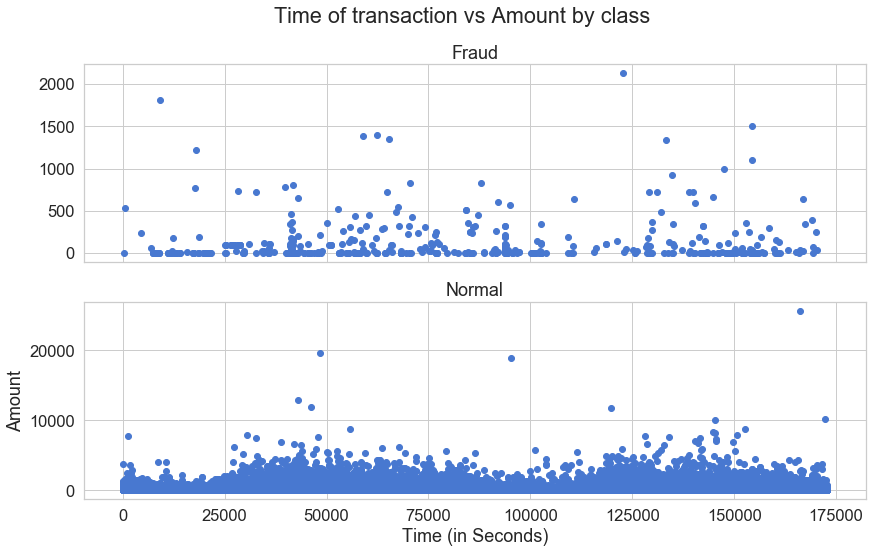

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [9]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
print(X_train.shape)
print(X_test.shape)

(227451, 29)
(56962, 29)


In [10]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [37]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 21s 90us/step - loss: 0.7214 - acc: 0.6787 - val_loss: 0.7544 - val_acc: 0.6792
Epoch 2/100
227451/227451 [==============================] - 21s 93us/step - loss: 0.7212 - acc: 0.6780 - val_loss: 0.7531 - val_acc: 0.6796
Epoch 3/100
227451/227451 [==============================] - 21s 93us/step - loss: 0.7219 - acc: 0.6775 - val_loss: 0.7528 - val_acc: 0.6808
Epoch 4/100
227451/227451 [==============================] - 21s 93us/step - loss: 0.7212 - acc: 0.6781 - val_loss: 0.7687 - val_acc: 0.6600
Epoch 5/100
227451/227451 [==============================] - 21s 93us/step - loss: 0.7216 - acc: 0.6781 - val_loss: 0.7525 - val_acc: 0.6785
Epoch 6/100
227451/227451 [==============================] - 21s 94us/step - loss: 0.7219 - acc: 0.6784 - val_loss: 0.7555 - val_acc: 0.6719
Epoch 7/100
227451/227451 [==============================] - 21s 92us/step - loss: 0.7220 - acc: 0.6781

In [11]:
autoencoder = load_model('model.h5')

In [12]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

NameError: name 'history' is not defined

In [13]:
predictions = autoencoder.predict(X_test)

In [14]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [15]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.740638,0.001720
std,3.373115,0.041443
min,0.044237,0.000000
25%,0.236772,0.000000
50%,0.388934,0.000000
75%,0.622723,0.000000
max,261.862951,1.000000


In [17]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

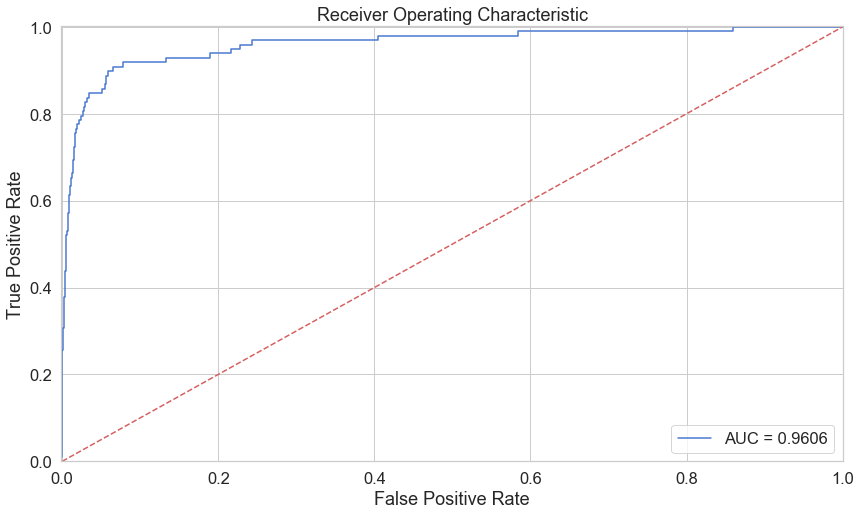

In [18]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

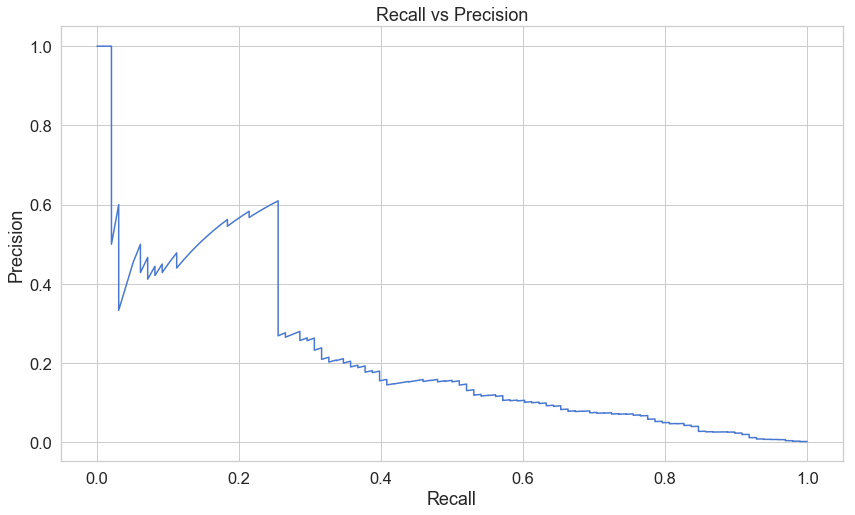

In [19]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [23]:
X_train

array([[  1.95504092e+00,  -3.80782711e-01,  -3.15012853e-01, ...,
          4.51682478e-02,  -4.71447917e-02,  -3.13288512e-01],
       [ -4.00975239e-01,  -6.26942769e-01,   1.55533881e+00, ...,
         -3.70468822e-01,  -1.44791686e-01,  -1.69717237e-01],
       [  7.25090164e-02,   8.20565650e-01,  -5.61350916e-01, ...,
          2.06394866e-01,   7.02877702e-02,  -3.05292340e-01],
       ..., 
       [ -1.46608925e-01,   9.92946123e-01,   1.52459137e+00, ...,
         -1.21139194e-01,  -1.96195328e-01,  -3.37476933e-01],
       [ -2.94863809e+00,   2.35484929e+00,  -2.52120111e+00, ...,
          4.96912107e-01,   3.35821632e-01,  -3.49231307e-01],
       [  1.23317435e+00,  -7.84850501e-01,   3.86783869e-01, ...,
          1.21657270e-03,   3.85878912e-02,   9.85543469e-02]])

In [24]:
threshold = 2.9

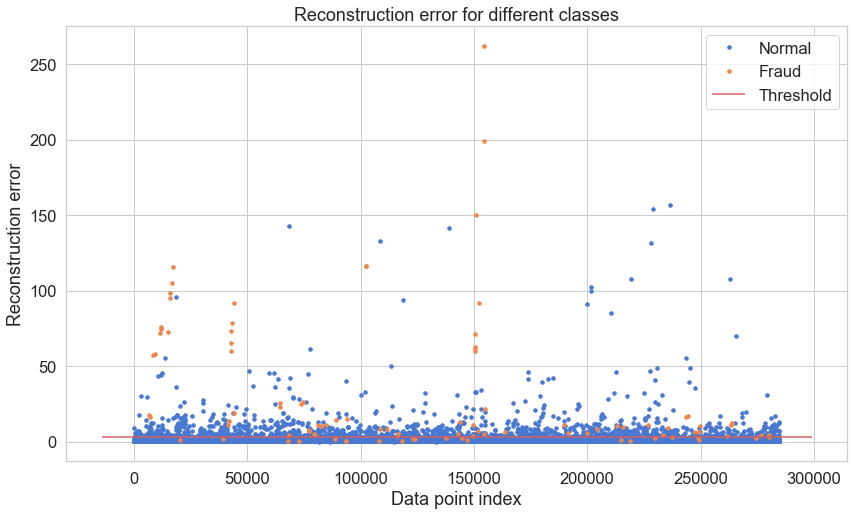

In [25]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

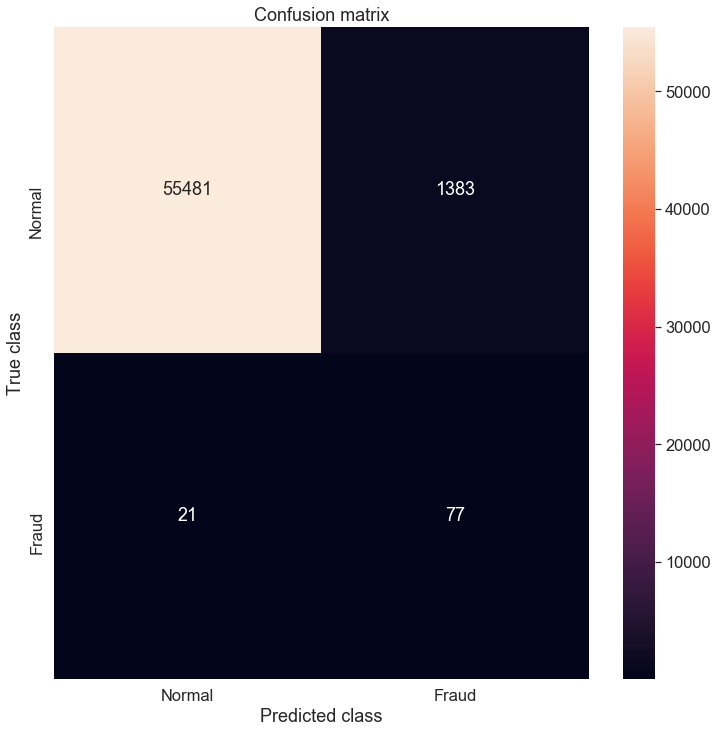

In [26]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()